In [1]:
!pip uninstall tensorflow

Uninstalling tensorflow-1.15.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/freeze_graph
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-1.15.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
    /usr/local/lib/python3.6/dist-packages/tensorflow_core/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-1.15.0


In [2]:
!pip install tensorflow==2.1.0

     |████████████████████████████████| 421.8MB 41kB/s 
     |████████████████████████████████| 3.8MB 43.5MB/s 
     |████████████████████████████████| 450kB 46.6MB/s 
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1


#**03_01**

In [14]:
import tensorflow as tf
import numpy as np
print(tf.__version__)
print(tf.test.is_gpu_available() == True)

2.1.0
True


In [0]:
from tensorflow.keras.callbacks import Callback,LearningRateScheduler,ModelCheckpoint
import os
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

In [40]:
# 실행 매개변수
SECTION = 'vae'
RUN_ID = '0001'
DATA_NAME = 'digits'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])
print(RUN_FOLDER)
if not os.path.exists(RUN_FOLDER):
  os.makedirs(RUN_FOLDER)
  os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
  os.mkdir(os.path.join(RUN_FOLDER, 'images'))
  os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

MODE =  'build' #'load' #

run/vae/0001_digits


In [0]:
#### CALLBACKS
class CustomCallback(Callback):
    
    def __init__(self, run_folder, print_every_n_batches, initial_epoch, vae):
        self.epoch = initial_epoch
        self.run_folder = run_folder
        self.print_every_n_batches = print_every_n_batches
        self.vae = vae

    def on_batch_end(self, batch, logs={}):  
        if batch % self.print_every_n_batches == 0:
            z_new = np.random.normal(size = (1,self.vae.z_dim))
            reconst = self.vae.decoder.predict(np.array(z_new))[0].squeeze()

            filepath = os.path.join(self.run_folder, 'images', 'img_' + str(self.epoch).zfill(3) + '_' + str(batch) + '.jpg')
            if len(reconst.shape) == 2:
                plt.imsave(filepath, reconst, cmap='gray_r')
            else:
                plt.imsave(filepath, reconst)

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch += 1



def step_decay_schedule(initial_lr, decay_factor=0.5, step_size=1):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        new_lr = initial_lr * (decay_factor ** np.floor(epoch/step_size))
        
        return new_lr

    return LearningRateScheduler(schedule)

In [0]:
import pickle


class Autoencoder():
  def __init__(self
        , input_dim
        , encoder_conv_filters
        , encoder_conv_kernel_size
        , encoder_conv_strides
        , decoder_conv_t_filters
        , decoder_conv_t_kernel_size
        , decoder_conv_t_strides
        , z_dim
        , use_batch_norm = False
        , use_dropout = False):
      self.name = 'autoencoder'

      self.input_dim = input_dim
      self.encoder_conv_filters = encoder_conv_filters
      self.encoder_conv_kernel_size = encoder_conv_kernel_size
      self.encoder_conv_strides = encoder_conv_strides
      self.decoder_conv_t_filters = decoder_conv_t_filters
      self.decoder_conv_t_kernel_size = decoder_conv_t_kernel_size
      self.decoder_conv_t_strides = decoder_conv_t_strides
      self.z_dim = z_dim

      self.use_batch_norm = use_batch_norm
      self.use_dropout = use_dropout

      self.n_layers_encoder = len(encoder_conv_filters)
      self.n_layers_decoder = len(decoder_conv_t_filters)

      self._build()

  def _build(self):

        ### THE ENCODER
      encoder_input = tf.keras.layers.Input(shape=self.input_dim, name='encoder_input')

      x = encoder_input

      for i in range(self.n_layers_encoder):
          conv_layer = tf.keras.layers.Conv2D(
              filters = self.encoder_conv_filters[i]
              , kernel_size = self.encoder_conv_kernel_size[i]
              , strides = self.encoder_conv_strides[i]
              , padding = 'same'
              , name = 'encoder_conv_' + str(i)
              )
          x = conv_layer(x)
          x = tf.keras.layers.LeakyReLU()(x)

          if self.use_batch_norm:
              x = tf.keras.layers.BatchNormalization()(x)

          if self.use_dropout:
              x = tf.keras.layers.Dropout(rate = 0.25)(x)

      shape_before_flattening = tf.keras.backend.int_shape(x)[1:]

      x = tf.keras.layers.Flatten()(x)
      encoder_output= tf.keras.layers.Dense(self.z_dim, name='encoder_output')(x)

      self.encoder = tf.keras.Model(encoder_input, encoder_output)


        ### THE DECODER
      decoder_input = tf.keras.layers.Input(shape=(self.z_dim,), name='decoder_input')

      x = tf.keras.layers.Dense(np.prod(shape_before_flattening))(decoder_input)
      x = tf.keras.layers.Reshape(shape_before_flattening)(x)

      for i in range(self.n_layers_decoder):
          conv_t_layer = tf.keras.layers.Conv2DTranspose(
              filters = self.decoder_conv_t_filters[i]
              , kernel_size = self.decoder_conv_t_kernel_size[i]
              , strides = self.decoder_conv_t_strides[i]
              , padding = 'same'
              , name = 'decoder_conv_t_' + str(i)
              )

          x = conv_t_layer(x)
          if i < self.n_layers_decoder - 1:
              x = tf.keras.layers.LeakyReLU()(x)
                
              if self.use_batch_norm:
                  x = tf.keras.layers.BatchNormalization()(x)
                
              if self.use_dropout:
                  x = tf.keras.layers.Dropout(rate = 0.25)(x)
          else:
              x = tf.keras.layers.Activation('sigmoid')(x)

      decoder_output = x

      self.decoder = tf.keras.Model(decoder_input, decoder_output)

      ### THE FULL AUTOENCODER
      model_input = encoder_input
      model_output = self.decoder(encoder_output)

      self.model = tf.keras.Model(model_input, model_output)

  def compile(self, learning_rate):
    self.learning_rate = learning_rate

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    def r_loss(y_true,y_pred):
      return tf.keras.backend.mean(tf.keras.backend.square(y_true-y_pred),axis=[1,2,3])

    self.model.compile(optimizer=optimizer , loss=r_loss)

  #def train(self,x_train,batch_size,epochs,print_every_n_batches=100,initial_epoch=0,lr_decay=1):

  def train(self, x_train, batch_size, epochs, run_folder, print_every_n_batches = 100, initial_epoch = 0, lr_decay = 1):

      custom_callback = CustomCallback(run_folder, print_every_n_batches, initial_epoch, self)
      lr_sched = step_decay_schedule(initial_lr=self.learning_rate, decay_factor=lr_decay, step_size=1)

      checkpoint2 = ModelCheckpoint(os.path.join(run_folder, 'weights/weights.h5'), save_weights_only = True, verbose=1)

      callbacks_list = [checkpoint2, custom_callback, lr_sched]

      self.model.fit(     
          x_train
          , x_train
          , batch_size = batch_size
          , shuffle = True
          , epochs = epochs
          , initial_epoch = initial_epoch
          , callbacks = callbacks_list
      )
  def save(self, folder):

      if not os.path.exists(folder):
          os.makedirs(folder)
          os.makedirs(os.path.join(folder, 'viz'))
          os.makedirs(os.path.join(folder, 'weights'))
          os.makedirs(os.path.join(folder, 'images'))

      with open(os.path.join(folder, 'params.pkl'), 'wb') as f:
          pickle.dump([
              self.input_dim
              , self.encoder_conv_filters
              , self.encoder_conv_kernel_size
              , self.encoder_conv_strides
              , self.decoder_conv_t_filters
              , self.decoder_conv_t_kernel_size
              , self.decoder_conv_t_strides
              , self.z_dim
              , self.use_batch_norm
              , self.use_dropout
              ], f)

      self.plot_model(folder)

  def load_weights(self, filepath):
      self.model.load_weights(filepath)

  def plot_model(self, run_folder):
      plot_model(self.model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)
      plot_model(self.encoder, to_file=os.path.join(run_folder ,'viz/encoder.png'), show_shapes = True, show_layer_names = True)
      plot_model(self.decoder, to_file=os.path.join(run_folder ,'viz/decoder.png'), show_shapes = True, show_layer_names = True)

In [0]:
AE = Autoencoder(
    input_dim = (28,28,1)
    , encoder_conv_filters = [32,64,64, 64]
    , encoder_conv_kernel_size = [3,3,3,3]
    , encoder_conv_strides = [1,2,2,1]
    , decoder_conv_t_filters = [64,64,32,1]
    , decoder_conv_t_kernel_size = [3,3,3,3]
    , decoder_conv_t_strides = [1,2,2,1]
    , z_dim = 2
)

if MODE == 'build':
    AE.save(RUN_FOLDER)
else:
    AE.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

In [0]:
from loaders import load_mnist
(x_train, y_train), (x_test, y_test) = load_mnist()

인코더


        encoder_input = Input(shape=self.input_dim, name='encoder_input')

        x = encoder_input

        for i in range(self.n_layers_encoder):
            conv_layer = Conv2D(
                filters = self.encoder_conv_filters[i]
                , kernel_size = self.encoder_conv_kernel_size[i]
                , strides = self.encoder_conv_strides[i]
                , padding = 'same'
                , name = 'encoder_conv_' + str(i)
                )

            x = conv_layer(x)

            x = LeakyReLU()(x)

            if self.use_batch_norm:
                x = BatchNormalization()(x)

            if self.use_dropout:
                x = Dropout(rate = 0.25)(x)

        shape_before_flattening = K.int_shape(x)[1:]

        x = Flatten()(x)
        encoder_output= Dense(self.z_dim, name='encoder_output')(x)

        self.encoder = Model(encoder_input, encoder_output)

In [0]:
AE.decoder.summary()

디코더

        decoder_input = Input(shape=(self.z_dim,), name='decoder_input')

        x = Dense(np.prod(shape_before_flattening))(decoder_input)
        x = Reshape(shape_before_flattening)(x)

        for i in range(self.n_layers_decoder):
            conv_t_layer = Conv2DTranspose(
                filters = self.decoder_conv_t_filters[i]
                , kernel_size = self.decoder_conv_t_kernel_size[i]
                , strides = self.decoder_conv_t_strides[i]
                , padding = 'same'
                , name = 'decoder_conv_t_' + str(i)
                )

            x = conv_t_layer(x)

            if i < self.n_layers_decoder - 1:
                x = LeakyReLU()(x)
                
                if self.use_batch_norm:
                    x = BatchNormalization()(x)
                
                if self.use_dropout:
                    x = Dropout(rate = 0.25)(x)
            else:
                x = Activation('sigmoid')(x)

        decoder_output = x

        self.decoder = Model(decoder_input, decoder_output)

오토인코더 훈련

In [0]:
LEARNING_RATE = 0.0005
BATCH_SIZE = 32
INITIAL_EPOCH = 0

In [0]:
AE.compile(LEARNING_RATE)

In [0]:
AE.train(     
    x_train[:1000]
    , batch_size = BATCH_SIZE
    , epochs = 200
    , run_folder = RUN_FOLDER
    , initial_epoch = INITIAL_EPOCH
)

#**03_02**


원본 그림 재구성

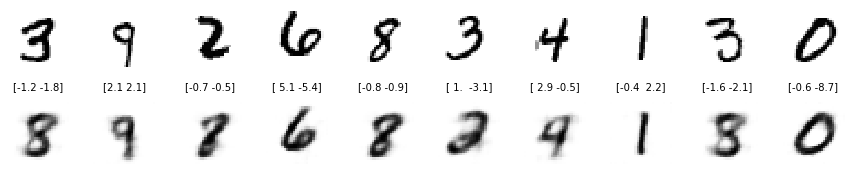

In [81]:
n_to_show = 10
np.random.seed(88)
example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]

z_points = AE.encoder.predict(example_images)

reconst_images = AE.decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(img, cmap='gray_r')

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')

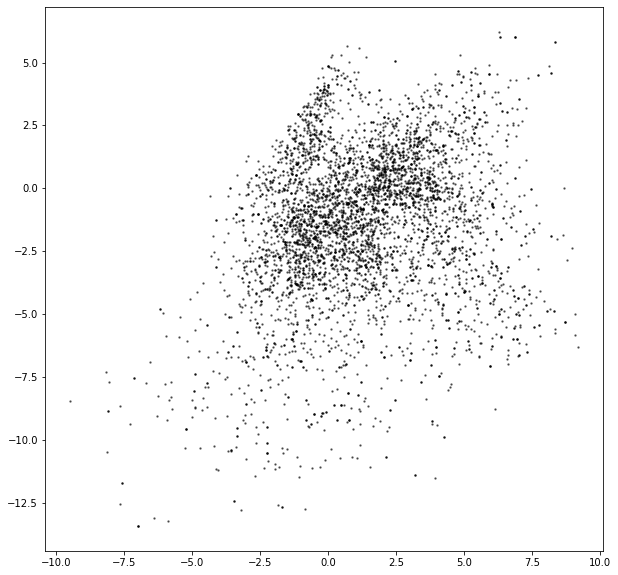

In [85]:
n_to_show = 5000
grid_size = 15
figsize = 10

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = AE.encoder.predict(example_images)

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)

plt.show()

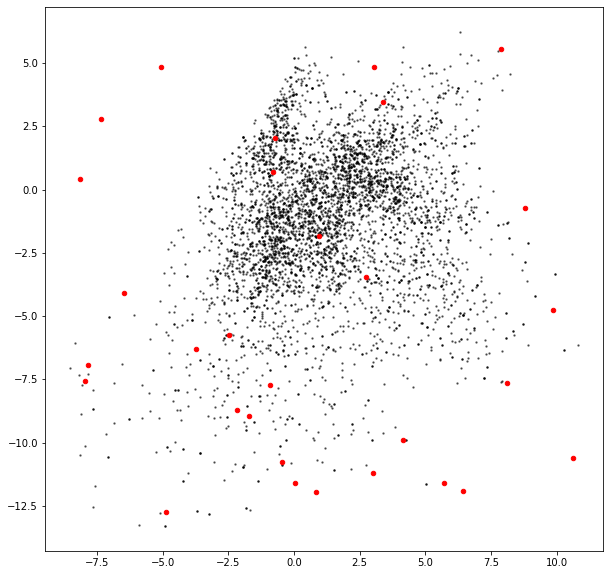

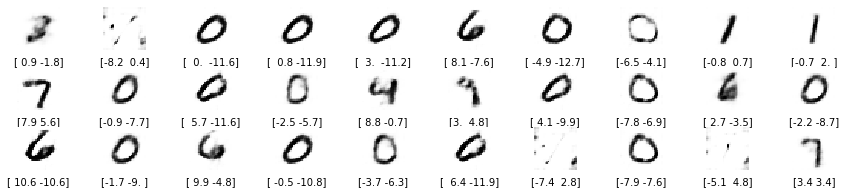

In [83]:
grid_size = 15
figsize = 10

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)

grid_size = 10
grid_depth = 3
figsize = 15

x = np.random.uniform(min_x, max_x, size = grid_size * grid_depth)
y = np.random.uniform(min_y, max_y, size = grid_size * grid_depth)
z_grid = np.array(list(zip(x, y)))
reconst = AE.decoder.predict(z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c='red', alpha=1, s=20)
plt.show()

fig = plt.figure(figsize=(figsize, grid_depth))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_size*grid_depth):
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_grid[i],1)), fontsize=10, ha='center', transform=ax.transAxes)
    
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')

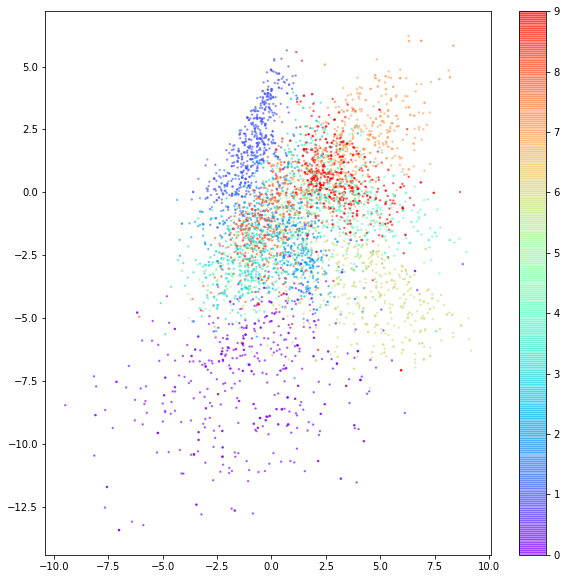

In [86]:
figsize = 10

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], cmap='rainbow', c=example_labels, alpha=0.5, s=2)
plt.colorbar()

plt.show()

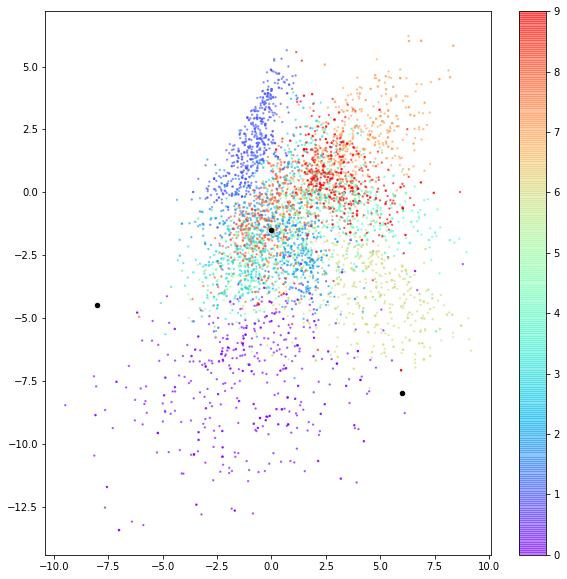

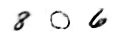

In [87]:
figsize = 10

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], cmap='rainbow', c=example_labels, alpha=0.5, s=2)
plt.colorbar()

bad_examples = np.array([[0, -1.5], [-8, -4.5], [6, -8]])
plt.scatter(bad_examples[:, 0] , bad_examples[:, 1], c='black', alpha=1, s=20)

plt.show()

reconst = AE.decoder.predict(bad_examples)

fig = plt.figure(figsize=(figsize, grid_depth))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(3):
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')

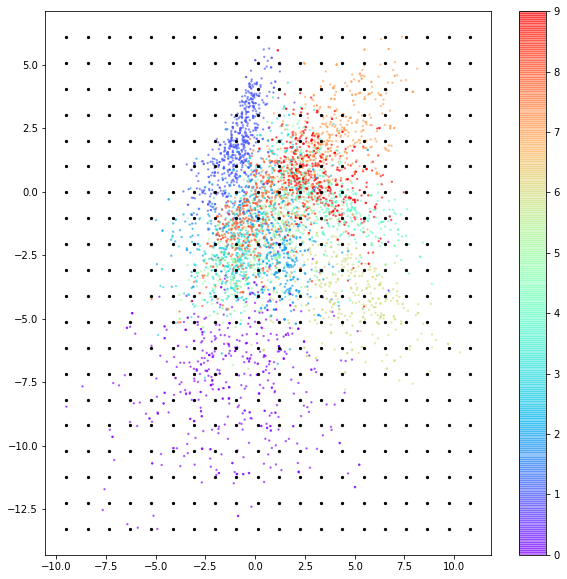

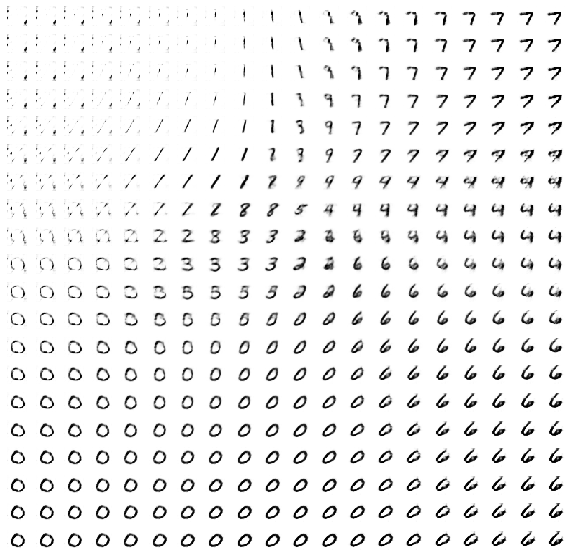

In [88]:
n_to_show = 5000
grid_size = 20

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = AE.encoder.predict(example_images)

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c=example_labels
            , alpha=0.5, s=2)
plt.colorbar()

# x = norm.ppf(np.linspace(0.05, 0.95, 10))
# y = norm.ppf(np.linspace(0.05, 0.95, 10))
x = np.linspace(min(z_points[:, 0]), max(z_points[:, 0]), grid_size)
y = np.linspace(max(z_points[:, 1]), min(z_points[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
z_grid = np.array(list(zip(xv, yv)))

reconst = AE.decoder.predict(z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'black'#, cmap='rainbow' , c= example_labels
            , alpha=1, s=5)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i+1)
    ax.axis('off')
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')